# Analysis of Data 3 with XGBoost

In this botebook, I will analyze data 3 '3year.arff' using the Ensemble Method 'XGBoost', eXtreme Gradient Boosting.

My business goal is identifying whether the company will bankrupt or not in three years., I will focus on the performance of 'recall' metric in order to minimize false negatives. Besides, I will also keep an eye on 'f1', and 'AUC' metrics.

## Load Libraries

In [1]:
# Import base libraries
import pandas as pd
import numpy as np
from scipy.io import arff

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.utils import class_weight

from functions import *

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

## Load Data

There are five data files: 
    * data1, 1year.arff 
    * data2, 2year.arff 
    * data3, 3year.arff
    * data4, 4year.arff
    * data5, 5year.arff

Initially, I will explore the models on data3. After determing the final model design, I will apply it on other datasets and compare te results.

No cleaning applied to data. XGBoost Classifier can handle the missing values.

In [2]:
# Load data
data3 = arff.loadarff('data/3year.arff')
df3 = pd.DataFrame(data3[0])

# Change label/class  type
df3['class'] = df3['class'].astype('int64')

df3.shape

(10503, 65)

## Pre-process

In [3]:
# Assign target and predictor
y = df3['class']
X = df3.drop('class', axis=1)

# Sepearate data into train and test splist
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Scale/Normalize the predictor variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

print('X_train shape = ', X_train.shape)
print('y_train shape = ', y_train.shape)
print('X_test shape = ', X_test.shape)
print('y_test shape = ', y_test.shape)

X_train shape =  (8402, 64)
y_train shape =  (8402,)
X_test shape =  (2101, 64)
y_test shape =  (2101,)


## Model 1: Baseline Model


In [4]:
# Model 1: Baseline Model

xgbParams_1 = {
    'eval_metric': 'logloss', 
    'random_state': 42,
}

model_1 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams_1, 'model_1', 0, 1, 1)

Data 3 Classification Report:

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       1.00      1.00      1.00       388

    accuracy                           1.00      8402
   macro avg       1.00      1.00      1.00      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1994
           1       0.93      0.47      0.62       107

    accuracy                           0.97      2101
   macro avg       0.95      0.73      0.80      2101
weighted avg       0.97      0.97      0.97      2101



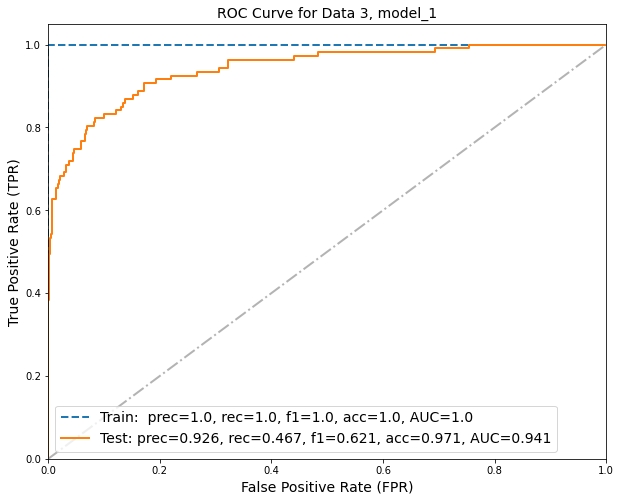

In [5]:
#Plot ROC curve

plot_ROC(3, X_train, y_train, X_test, y_test, model_1, 'model_1', 1)

In [7]:
model_1.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)>

**Comments**

* According to testing data results, the model performance in identfying the non-bankruptcy companies (class 0) is very good. 
* However, the identification of the bankruptcy companies (class 1) is not that good (low recall and f1)
* The class imbalance is probaly the reason for the class 0/1 performance difference.
* There is large overfitting.


## Class Imbalance

There are two approaches to deal with the class imbalance:
* 'scale_pos_weight' parameter when initiating the classifier
* 'sample_weight' parameter when training the data

In [8]:
#Check Class Imbalance
df3['class'].value_counts()

0    10008
1      495
Name: class, dtype: int64

In [9]:
#Check Class Imbalance, Normalized
df3['class'].value_counts(normalize=True)

0    0.952871
1    0.047129
Name: class, dtype: float64

### scale_pos_weight

My goal is find the optimum 'scale_pos_weight' value which creates good recall and f1 value.

The model performance is largely effected by the max_depth. So I will scan the scale_pos_weight at several max_depth.

In [10]:
# Explore class counts

val_counts = df3['class'].value_counts()
ratio_imbalance = val_counts[0]/val_counts[1]
sqrt_ratio_imbalance = np.sqrt(val_counts[0]/val_counts[1])

print('imbalance ratio:', ratio_imbalance)
print('sqrt of imbalance ratio:', sqrt_ratio_imbalance)

imbalance ratio: 20.21818181818182
sqrt of imbalance ratio: 4.496463256625347


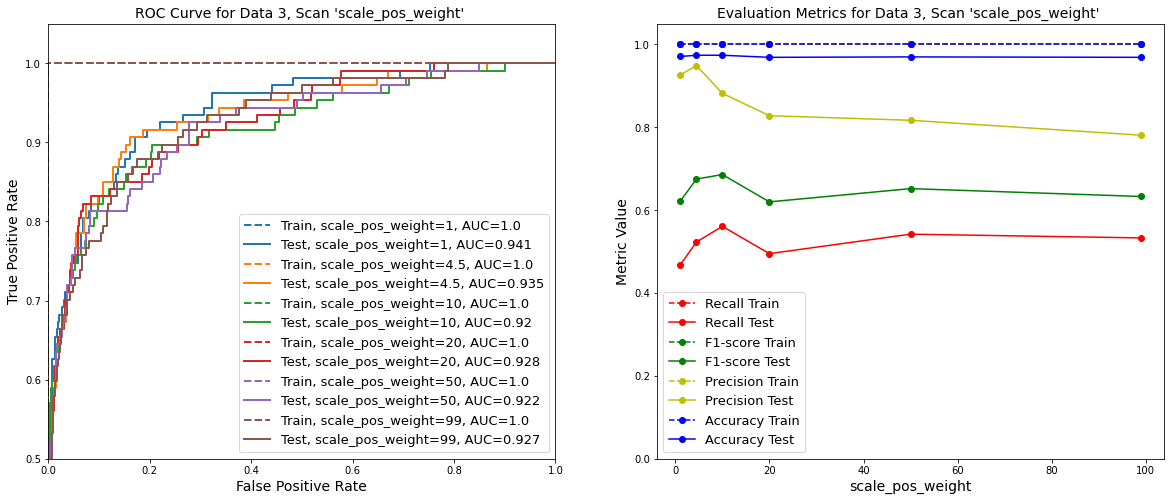

In [18]:
#Scan scale_pos_weight, default max_depth=6

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
}

scanParam = 'scale_pos_weight'

scanList = [1, 4.5, 10, 20, 50, 99]
#scanList = [1, 4.5]

result_spw = scan_xgb_ROC_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0, 1, 0)

In [5]:
# scale_pos_weight=10

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 10,
}

xgb_model_spw10 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams, 'XGB Model', 0, 0, 1)

Data 3 Classification Report:

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       1.00      1.00      1.00       388

    accuracy                           1.00      8402
   macro avg       1.00      1.00      1.00      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1994
           1       0.88      0.56      0.69       107

    accuracy                           0.97      2101
   macro avg       0.93      0.78      0.84      2101
weighted avg       0.97      0.97      0.97      2101



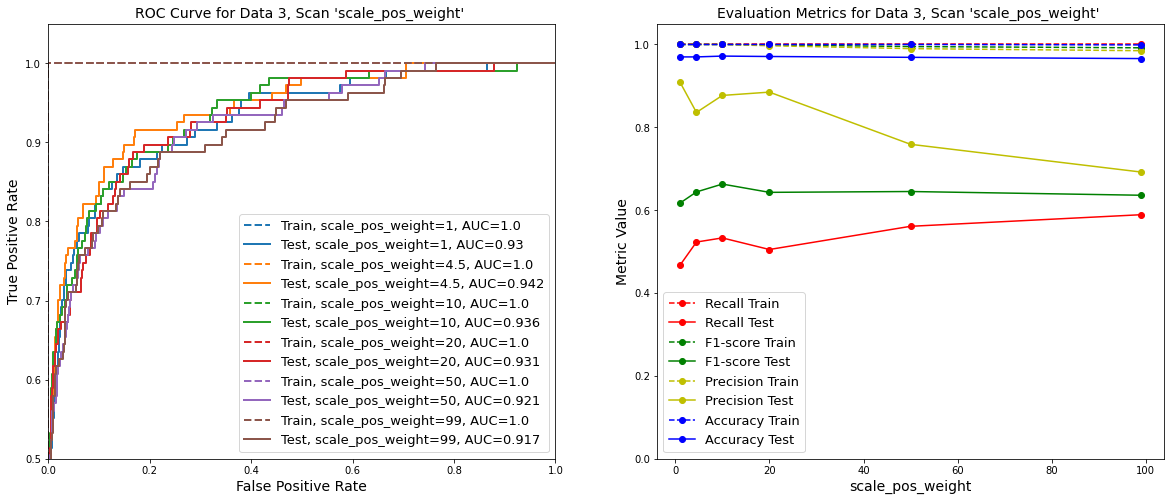

In [10]:
#Scan scale_pos_weight, default max_depth=5

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 5
}

scanParam = 'scale_pos_weight'

scanList = [1, 4.5, 10, 20, 50, 99]

result_spw_depth5 = scan_xgb_ROC_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0, 1, 0)

**Comments**
* The model performance improves compared to the baseline model (Model 1) where default scale_pos_weight=1.
* The optimum value may be different when other parameters change, for instance max_depth.
* The optimum scale_pos_weight:
    * scale_pos_weight=10 at max_depth=6
    * scale_pos_weight=50 at max_depth=5
* Overfitting observed.
* The optimum value may be different when another data set is used. It will require additional parameter tuning.

### class_weight

In [12]:
# Whole data 3
print('Whole Data3')
d3_class_weights_all = class_weight.compute_class_weight(class_weight='balanced', classes=[0,1], y=df3['class'])
print(d3_class_weights_all)
weights_ratio = d3_class_weights_all[1]/d3_class_weights_all[0]
print('weights_ratio', weights_ratio)
print('Squared Root of weights_ratio', np.sqrt(weights_ratio))

Whole Data3
[ 0.52473022 10.60909091]
weights_ratio 20.21818181818182
Squared Root of weights_ratio 4.496463256625347


In [13]:
#Training sample

print('Training sample')
print(class_weight.compute_class_weight(class_weight='balanced', classes=[0,1], y=y_train))

d3_class_weights_train = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
print('d3 Class weights:', d3_class_weights_train)

Training sample
[ 0.52420764 10.82731959]
d3 Class weights: [0.52420764 0.52420764 0.52420764 ... 0.52420764 0.52420764 0.52420764]


In [6]:
# sample_weight

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
}

xgb_model_sw = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams, 'XGB Model', 1, 0, 1)

Sample weights are used!
--------

Data 3 Classification Report:

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       1.00      1.00      1.00       388

    accuracy                           1.00      8402
   macro avg       1.00      1.00      1.00      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1994
           1       0.87      0.54      0.67       107

    accuracy                           0.97      2101
   macro avg       0.92      0.77      0.83      2101
weighted avg       0.97      0.97      0.97      2101



**Comments**

* Compared the baseline model, model with sample_weight applied shows an improved performance, especially recall value.
* The performance is very slightly lower than to the model with scale_pos_weight applied.


### class_weight + scale_pos_weight


In [7]:
# class_weight + scale_pos_weight
# 'scale_pos_weight': 10

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 10
}
   
xgb_model_sw_spw10 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams, 'XGB Model', 1, 0, 1)

Sample weights are used!
--------

Data 3 Classification Report:

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       0.99      1.00      1.00       388

    accuracy                           1.00      8402
   macro avg       1.00      1.00      1.00      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1994
           1       0.73      0.60      0.66       107

    accuracy                           0.97      2101
   macro avg       0.85      0.79      0.82      2101
weighted avg       0.97      0.97      0.97      2101



Sample weights are used!
--------



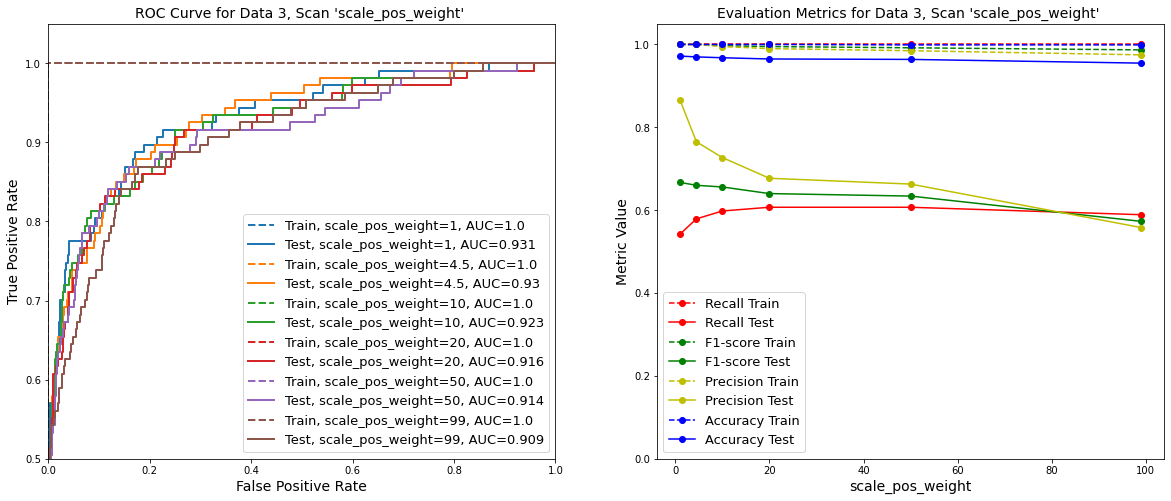

In [19]:
#Scan scale_pos_weight
# sample_weight applied
#max_depth=6

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
}

scanParam = 'scale_pos_weight'

scanList = [1, 4.5, 10, 20, 50, 99]
#scanList = [1, 4.5]

result_spw_sw = scan_xgb_ROC_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 1, 1, 0)

Sample weights are used!
--------



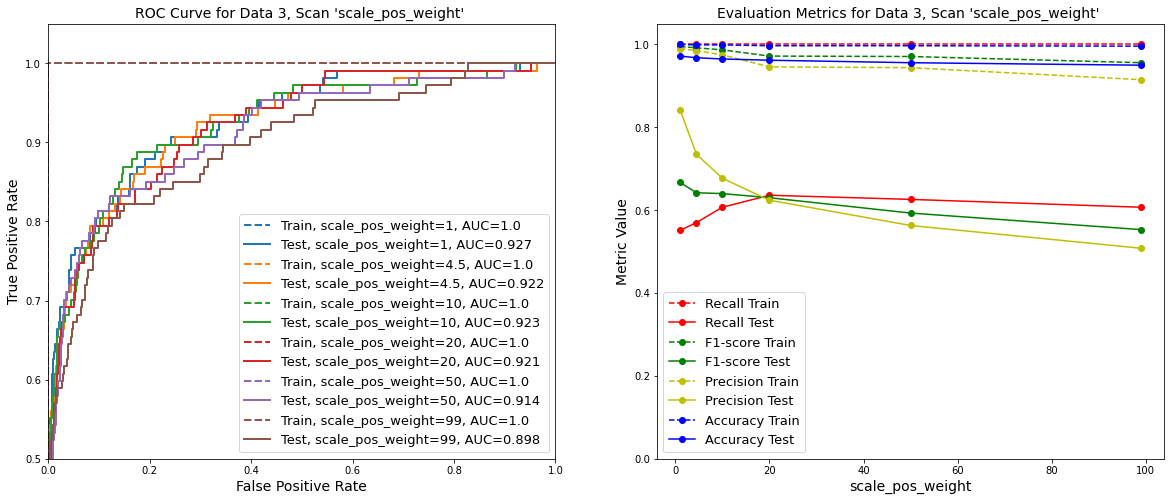

In [47]:
#Scan scale_pos_weight
# sample_weight applied
# max_depth=5

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 5,
}

scanParam = 'scale_pos_weight'

scanList = [1, 4.5, 10, 20, 50, 99]
#scanList = [1, 4.5]

result_spw_sw_depth5 = scan_xgb_ROC_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 1, 1, 0)


Sample weights are used!
--------



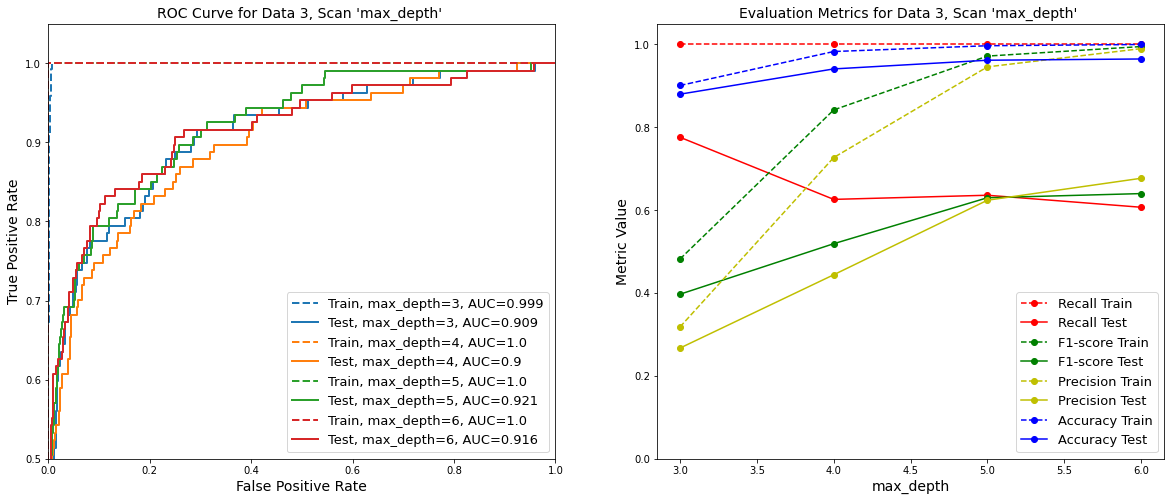

In [30]:
#Scan max_depth
# sample_weight applied
# scale_pos_weight=20

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42, 
    'scale_pos_weight': 20

}

scanParam = 'max_depth'

scanList = [3, 4, 5, 6]

result_ = scan_xgb_ROC_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 1, 1, 0)

In [8]:
xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 20
}
   
xgb_model_sw_spw20 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams, 'XGB Model', 1, 0, 1)

Sample weights are used!
--------

Data 3 Classification Report:

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       0.99      1.00      0.99       388

    accuracy                           1.00      8402
   macro avg       0.99      1.00      1.00      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1994
           1       0.68      0.61      0.64       107

    accuracy                           0.97      2101
   macro avg       0.83      0.80      0.81      2101
weighted avg       0.96      0.97      0.96      2101



In [9]:
#Compare, at max_depth=6

model_list = [xgb_model_spw10, xgb_model_sw, xgb_model_sw_spw10, xgb_model_sw_spw20]

model_names_list = ['scale_pos_weight=10', 'sample_weight', 'sample_weight + scale_pos_weight=10', 'sample_weight + scale_pos_weight=20']

compare_models(3, X_train, y_train, X_test, y_test, model_list, model_names_list, 'imbalance_depth6', 0, 0)


,precision,recall,f1,accuracy,auc
Params,,,,,
scale_pos_weight=10 Train,1.000,1.000,1.000,1.000,1.000
Test,0.882,0.561,0.686,0.974,0.920
sample_weight Train,1.000,1.000,1.000,1.000,1.000
Test,0.866,0.542,0.667,0.972,0.931
sample_weight + scale_pos_weight=10 Train,0.995,1.000,0.997,1.000,1.000
Test,0.727,0.598,0.656,0.968,0.923
sample_weight + scale_pos_weight=20 Train,0.990,1.000,0.995,1.000,1.000
Test,0.677,0.607,0.640,0.965,0.916


**Comments**

* Using sample_weight and scale_pos_weight together increased the performance at max_depth=6


### Model 2: Model with Class Imbalance treated

In [6]:
# Model 2: Baseline Model + sample_weight + 'scale_pos_weight=20'

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 20,
}

model_2 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams, 'model_2', 1, 1, 1)

Sample weights are used!
--------

Data 3 Classification Report:

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       0.99      1.00      0.99       388

    accuracy                           1.00      8402
   macro avg       0.99      1.00      1.00      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1994
           1       0.68      0.61      0.64       107

    accuracy                           0.97      2101
   macro avg       0.83      0.80      0.81      2101
weighted avg       0.96      0.97      0.96      2101



In [35]:
model_2.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=20, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)>

,precision,recall,f1,accuracy,auc
Params,,,,,
Model 1 Train,1.000,1.000,1.000,1.000,1.000
Test,0.926,0.467,0.621,0.971,0.941
Model 2 Train,0.990,1.000,0.995,1.000,1.000
Test,0.677,0.607,0.640,0.965,0.916


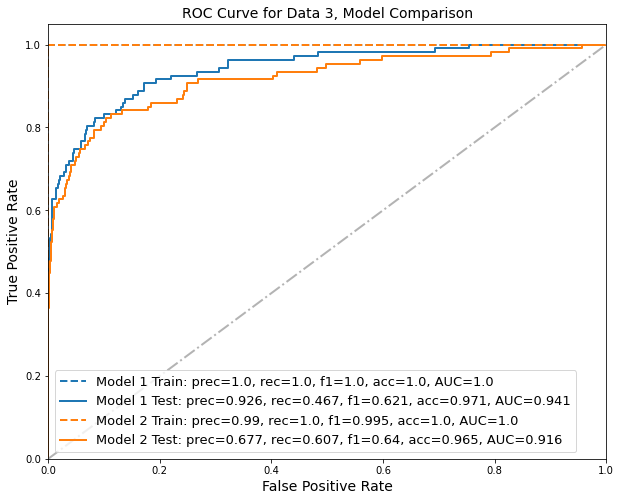

In [12]:
model_list = [model_1, model_2]
model_names_list = ['Model 1', 'Model 2']

compare_models(3, X_train, y_train, X_test, y_test, model_list, model_names_list, 'Model_1-2', 1, 1)

**Comments**

* Model 2 shows an improvement compared to Model 1.
* recall and f1 increased, even though precision and AUC decreased,
* Overfitting is still strong.

## Parameter Tuning and Overfitting

The ovefitting looks a like a main issue at this point.

I will try to control overfitting by tuning the XGBoost Classifier Parameters, while trying to improve the model at the same time.

I will first use GridSearchCV on few parameters to obtain best performance parameters. Then, I will deeper look in parameters that effect overfitting.

The paramaters that can affect overfitting are grouped in four categories:

1. Boosting Rounds
    * n_estimators
2. Pruning:
    * max_depth
    * min_child_weight
    * gamma   
3. Regularization:
    * learning_rate
    * max_delta_step
    * reg_lambda
    * reg_alpha     
4. Sampling
    * subsample
    * colsample_bytree

## Parameter Tuning with GridSearchCV

Scoring = 'f1'

Even though, my focus is on 'recall', I will use f1 in GridSearchCV to obtain overall good performance.

I will only use sample_weight method for parameter tuning. I choose not to use 'scale_pos_weight' during grid search, since the optimum value varies depending on the max_depth and other parameters. After parameter tuning, I will find the optimum scale_pos_weight.

In [12]:
# Parameter Tuning with GridSearhCV

start=datetime.now()

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'tree_method': 'hist' #Train faster, default: 'exact'
}

xgb_param_grid = {
    'n_estimators': [50, 100, 150], #default: 100
    'max_depth': [3, 4, 5, 6], # default: 3
    'min_child_weight': [1, 2, 3], #default: 1
    'learning_rate': [0.1, 0.2, 0.3], # default: 0.1
    'subsample': [0.5, 0.7, 1] #default: 1
}

d3_weigths_train = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)

xgb = XGBClassifier(**xgbParams) 
xgb_gs = GridSearchCV(xgb, xgb_param_grid, cv=3, scoring='f1')
xgb_gs.fit(X_train, y_train, sample_weight=d3_weigths_train)

print('Parameter Tuning Results:\n')
print("Best Parameter Combination:", xgb_gs.best_params_)
print('Training Data:\n', classification_report(y_train, xgb_gs.predict(X_train)))
print('Testing Data:\n', classification_report(y_test, xgb_gs.predict(X_test)))

end=datetime.now()

print('Process time:', end-start)

Parameter Tuning Results:

Best Parameter Combination: {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 1}
Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       0.98      1.00      0.99       388

    accuracy                           1.00      8402
   macro avg       0.99      1.00      0.99      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1994
           1       0.81      0.59      0.68       107

    accuracy                           0.97      2101
   macro avg       0.89      0.79      0.83      2101
weighted avg       0.97      0.97      0.97      2101

Process time: 0:19:02.448128


### Model 3: Model after GridSearchCV Parameter Tuning

I will use Grid Search Parameters. 
And add 'scale_pos_weight': 20

In [8]:
# Model 3: Model after GridSearchCV Parameter Tuning

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 20,
    'n_estimators': 150, 
    'max_depth': 5,
    'min_child_weight': 1,
    'learning_rate': 0.20,
    'subsample': 1,
}

model_3 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams, 'model_3', 1, 1, 1)

Sample weights are used!
--------

Data 3 Classification Report:

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       0.96      1.00      0.98       388

    accuracy                           1.00      8402
   macro avg       0.98      1.00      0.99      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1994
           1       0.64      0.64      0.64       107

    accuracy                           0.96      2101
   macro avg       0.81      0.81      0.81      2101
weighted avg       0.96      0.96      0.96      2101



In [74]:
model_3.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=20, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)>

,precision,recall,f1,accuracy,auc
Params,,,,,
Model 1 Train,1.000,1.000,1.000,1.000,1.000
Test,0.926,0.467,0.621,0.971,0.941
Model 2 Train,0.990,1.000,0.995,1.000,1.000
Test,0.677,0.607,0.640,0.965,0.916
Model 3 Train,0.956,1.000,0.977,0.998,1.000
Test,0.645,0.645,0.645,0.964,0.922


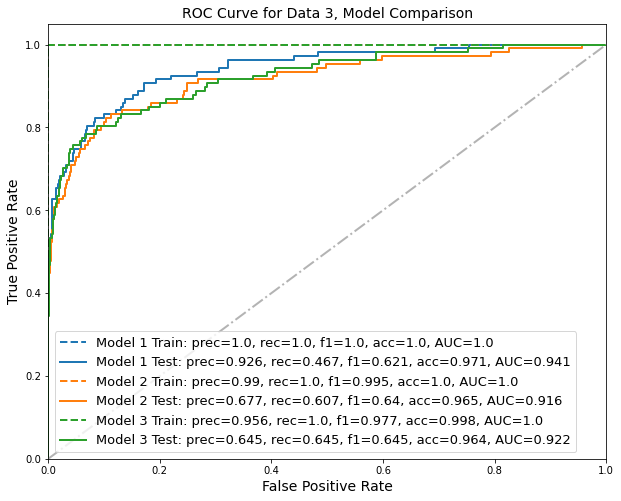

In [11]:
model_list = [model_1, model_2, model_3]
model_names_list = ['Model 1', 'Model 2', 'Model 3']

compare_models(3, X_train, y_train, X_test, y_test, model_list, model_names_list, 'Model_1-3', 1, 1)

**Comments**

* Model 3 has improved recall and f1 value.
* Overfitting decresed sligltly.

## Parameter Tuning with Boosting Rounds

### n_estimators

I will explore the Log Loss function first.

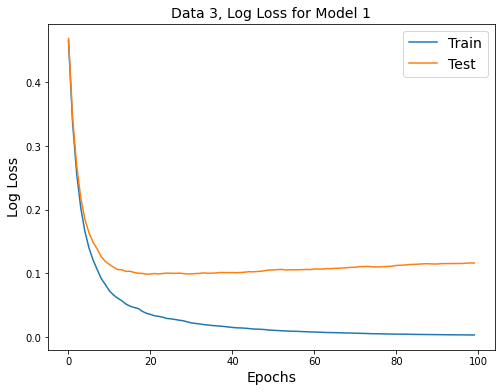

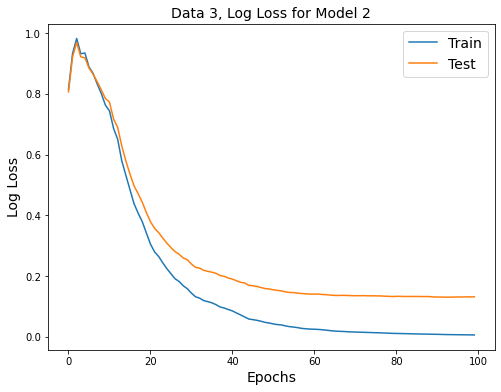

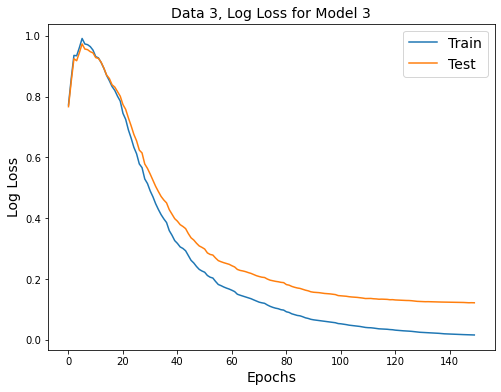

In [51]:
# Model 1, 2, 3 LogLoss

plot_logloss(3, model_1, 'Model 1', 0)
plot_logloss(3, model_2, 'Model 2', 0)
plot_logloss(3, model_3, 'Model 3', 0)

Sample weights are used!
--------



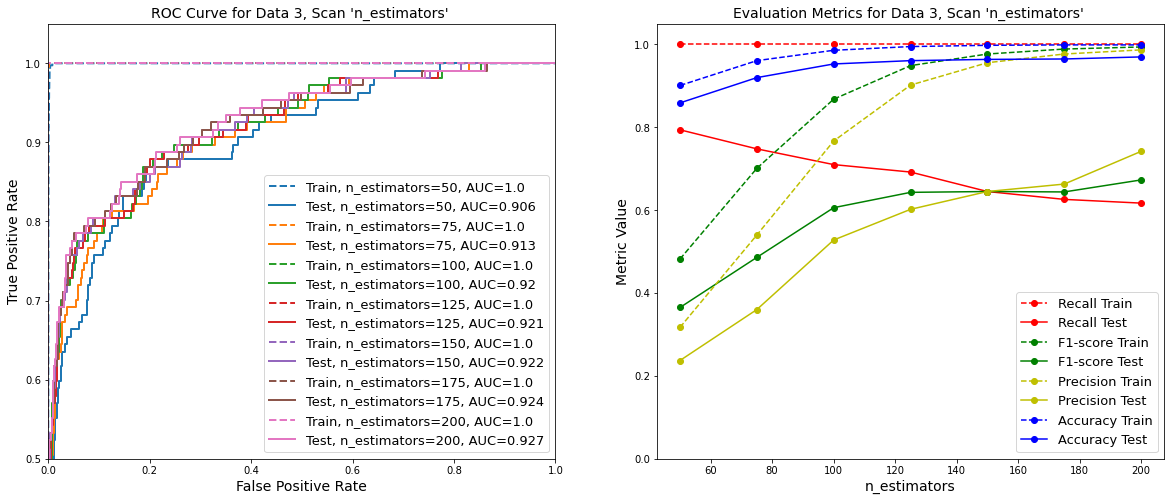

In [52]:
# Scan n_estimators

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 20,
    'max_depth': 5,
    'min_child_weight': 1,
    'learning_rate': 0.20,
    'subsample': 1,
}

scanParam = 'n_estimators'

scanList = [50, 75, 100, 125, 150, 175, 200]

results_est = scan_xgb_ROC_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 1, 1, 0)

**Comments**

* Overfitting increases as n_estimator increases
* Optimum n_estimator = 125 for Model 3 paramaters

**Early Stopping**

I tried to use 'early_stopping rounds', but for some reason it didn't work. The system chooses to ignore the parameter, even though train/fit runs without an error.

### Model 4: Model after n_estimator Tuninng

In [13]:
# Model 4: Model after n_estimator Tuninng

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 20,
    'n_estimators': 125, 
    'max_depth': 5,
    'min_child_weight': 1,
    'learning_rate': 0.20,
    'subsample': 1,
}

model_4 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams, 'model_4', 1, 1, 1)

Sample weights are used!
--------

Data 3 Classification Report:

Training Data:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      8014
           1       0.90      1.00      0.95       388

    accuracy                           1.00      8402
   macro avg       0.95      1.00      0.97      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1994
           1       0.60      0.69      0.64       107

    accuracy                           0.96      2101
   macro avg       0.79      0.83      0.81      2101
weighted avg       0.96      0.96      0.96      2101



In [75]:
model_4.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=125, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=20, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)>

,precision,recall,f1,accuracy,auc
Params,,,,,
Model 1 Train,1.000,1.000,1.000,1.000,1.000
Test,0.926,0.467,0.621,0.971,0.941
Model 2 Train,0.990,1.000,0.995,1.000,1.000
Test,0.677,0.607,0.640,0.965,0.916
Model 3 Train,0.956,1.000,0.977,0.998,1.000
Test,0.645,0.645,0.645,0.964,0.922
Model 4 Train,0.902,1.000,0.949,0.995,1.000
Test,0.602,0.692,0.643,0.961,0.921


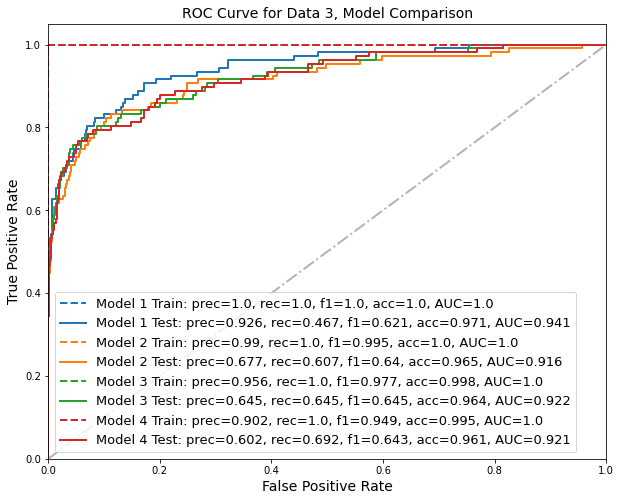

In [25]:
model_list = [model_1, model_2, model_3, model_4]
model_names_list = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

compare_models(3, X_train, y_train, X_test, y_test, model_list, model_names_list, 'Model_l-4', 1, 1)

In [72]:
model_4.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=125, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=20, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)>

**Comments**

* Recall increased
* Overfitting sligtly decreased.

## Pruning Parameters Tuning 

### max_depth

Sample weights are used!
--------



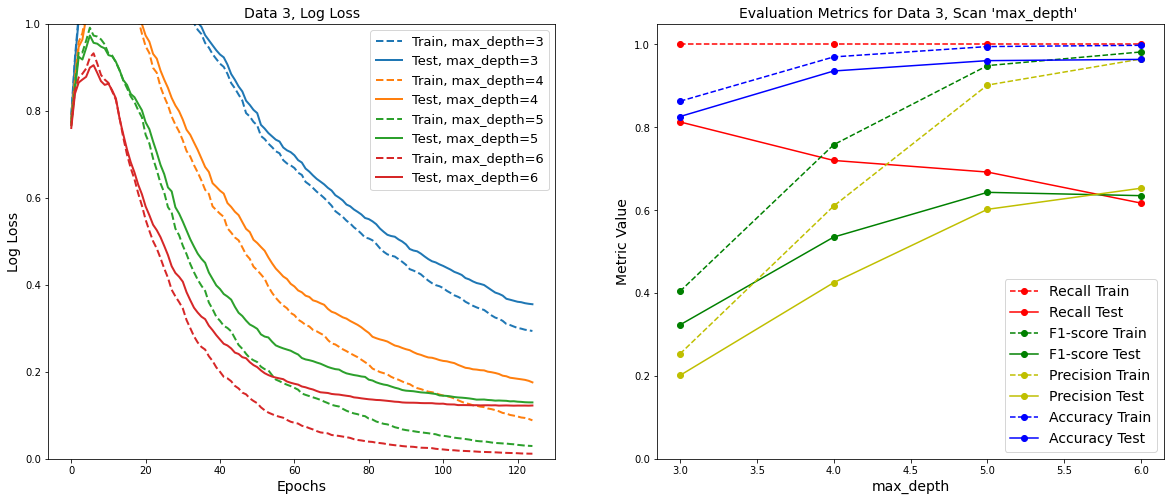

In [60]:
#Scan max_depth

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 20,
    'n_estimators': 125, 
    #'max_depth': 5,
    'min_child_weight': 1,
    'learning_rate': 0.20,
    'subsample': 1,
}

scanParam = 'max_depth'

scanList = [3, 4, 5, 6]

result_depth = scan_xgb_logloss_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 1, 1, 0)

**Comments**

* Overfitting decreases as the the max_depth increases.
* The 'recall' values also drops, as max_depth decreases.
* Optimum: max_depth=5.

### min_child_weight

Sample weights are used!
--------



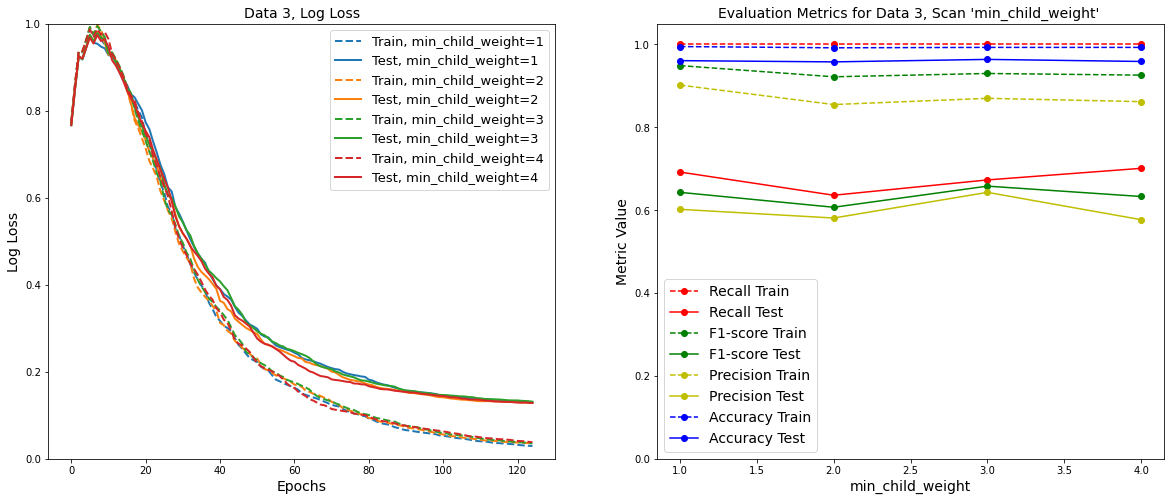

In [61]:
#Scan min_child_weight

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 20,
    'n_estimators': 125, 
    'max_depth': 5,
    #'min_child_weight': 1,
    'learning_rate': 0.20,
    'subsample': 1,
}

scanParam = 'min_child_weight'

scanList = [1, 2, 3, 4]

result_child = scan_xgb_logloss_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 1, 1, 0)

In [62]:
result_child

,precision,recall,f1,accuracy,logloss
Params,,,,,
min_child_weight=1 Train,0.902,1.000,0.949,0.995,0.029
Test,0.602,0.692,0.643,0.961,0.129
min_child_weight=2 Train,0.855,1.000,0.922,0.992,0.035
Test,0.581,0.636,0.607,0.958,0.129
min_child_weight=3 Train,0.870,1.000,0.930,0.993,0.035
Test,0.643,0.673,0.658,0.964,0.131
min_child_weight=4 Train,0.862,1.000,0.926,0.993,0.038
Test,0.577,0.701,0.633,0.959,0.128


**Comments**

* min_child_weight has slight effect on model performance and overfitting.
* Optimum min_child_weight=3
    * f1 drops a bit
    * but ovefitting decreases some.

### gamma

Sample weights are used!
--------



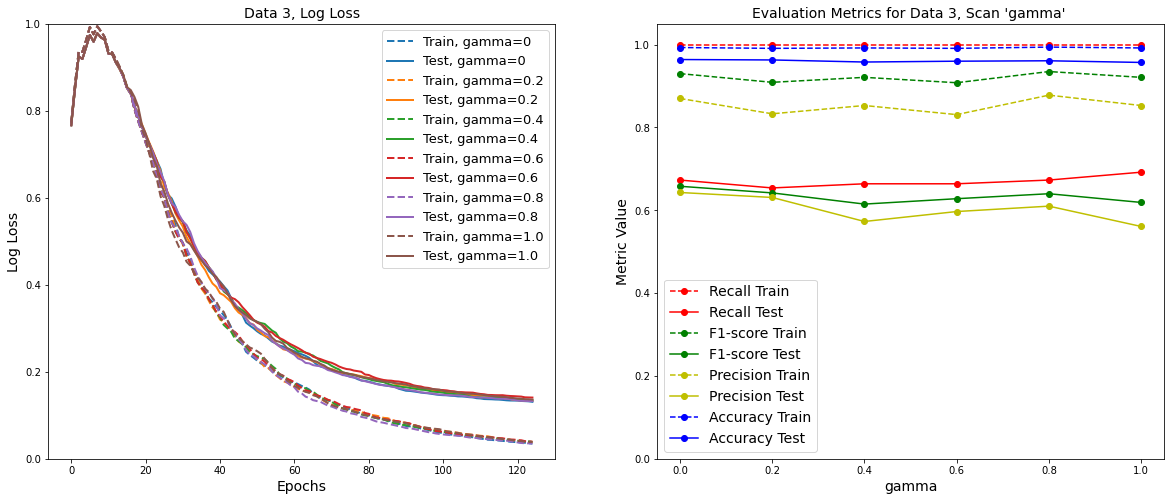

In [64]:
#Scan gamma

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 20,
    'n_estimators': 125, 
    'max_depth': 5,
    'min_child_weight': 3,
    'learning_rate': 0.20,
    'subsample': 1,
}

scanParam = 'gamma'

scanList = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

result_gamma = scan_xgb_logloss_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 1, 1, 0)

In [65]:
result_gamma

,precision,recall,f1,accuracy,logloss
Params,,,,,
gamma=0 Train,0.870,1.000,0.930,0.993,0.035
Test,0.643,0.673,0.658,0.964,0.131
gamma=0.2 Train,0.833,1.000,0.909,0.991,0.038
Test,0.631,0.654,0.642,0.963,0.134
gamma=0.4 Train,0.853,1.000,0.921,0.992,0.039
Test,0.573,0.664,0.615,0.958,0.135
gamma=0.6 Train,0.831,1.000,0.908,0.991,0.040
Test,0.597,0.664,0.628,0.960,0.141
gamma=0.8 Train,0.878,1.000,0.935,0.994,0.035


**Comments**

* The model performance and overfitting didn't improve much.
* Overfitting increase for higher gamma values.
* Selected gamma=0 (default)

### Model 5: Model after Pruning

In [15]:
# Model 5: Model after Pruning

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 20,
    'n_estimators': 125, 
    'max_depth': 5,
    'min_child_weight': 3,
    'gamma': 0,
    'learning_rate': 0.20,
    'subsample': 1,
}

model_5 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams, 'model_5', 1, 1, 1)

Sample weights are used!
--------

Data 3 Classification Report:

Training Data:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      8014
           1       0.87      1.00      0.93       388

    accuracy                           0.99      8402
   macro avg       0.93      1.00      0.96      8402
weighted avg       0.99      0.99      0.99      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1994
           1       0.64      0.67      0.66       107

    accuracy                           0.96      2101
   macro avg       0.81      0.83      0.82      2101
weighted avg       0.97      0.96      0.96      2101



In [77]:
model_5.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=5, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=125, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=20, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)>

,precision,recall,f1,accuracy,auc
Params,,,,,
Model 1 Train,1.000,1.000,1.000,1.000,1.000
Test,0.926,0.467,0.621,0.971,0.941
Model 2 Train,0.990,1.000,0.995,1.000,1.000
Test,0.677,0.607,0.640,0.965,0.916
Model 3 Train,0.956,1.000,0.977,0.998,1.000
Test,0.645,0.645,0.645,0.964,0.922
Model 4 Train,0.902,1.000,0.949,0.995,1.000
Test,0.602,0.692,0.643,0.961,0.921
Model 5 Train,0.870,1.000,0.930,0.993,1.000


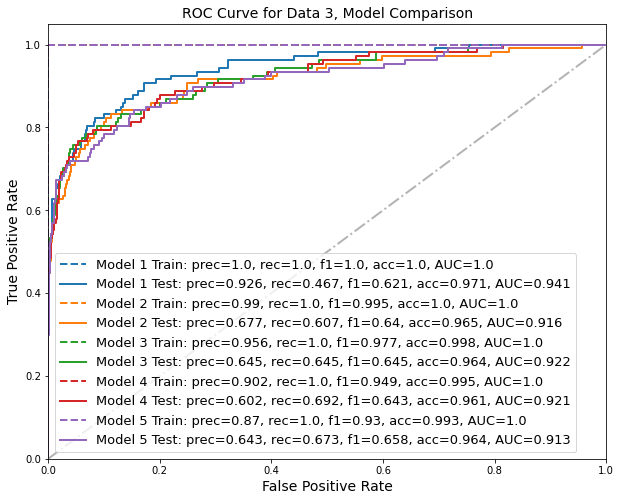

In [24]:
model_list = [model_1, model_2, model_3, model_4, model_5]
model_names_list = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5']

compare_models(3, X_train, y_train, X_test, y_test, model_list, model_names_list, 'Model_l-5', 1, 1)

**Comments**

* Overfitting decreased.
* Recall and AUC decreased.
* f1 and precision increased.

## Regularization Parameters Tuning

### learning_rate

Sample weights are used!
--------



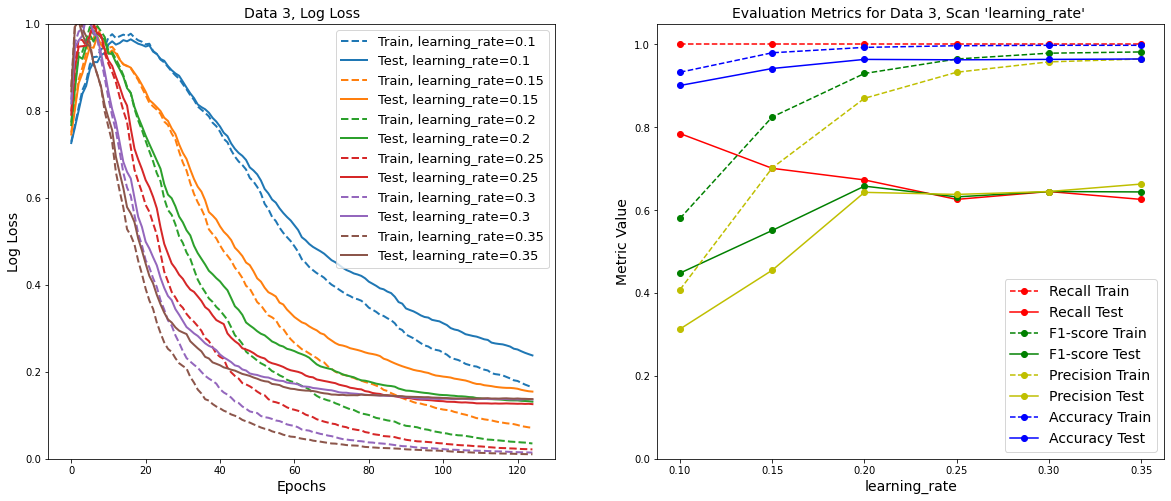

In [69]:
#Scan learning_rate, 
#'min_child_weight': 3

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 20,
    'n_estimators': 125, 
    'max_depth': 5,
    'min_child_weight': 3,
    'gamma': 0,
    #'learning_rate': 0.20,
    'subsample': 1,
}

scanParam = 'learning_rate'

scanList = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35]

result_learnRate = scan_xgb_logloss_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 1, 1, 0)


**Comments**

* As learning_rate increases:
    * Overfitting increases
    * recall decreases
    * f1 and precision increases
* Optimum learning_rate=0.20, agrees with GridSearchCV.

### max_delta_step

Sample weights are used!
--------



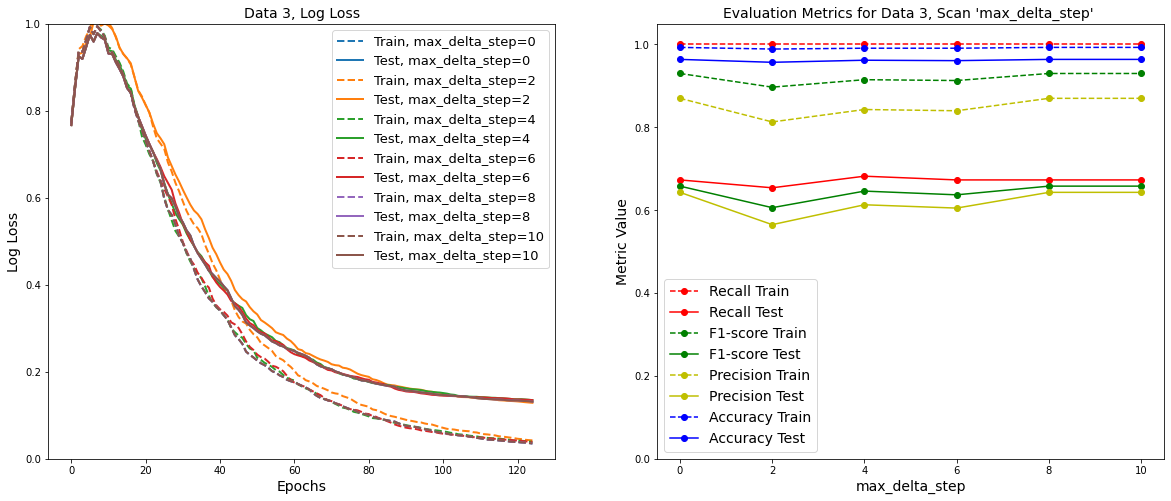

In [80]:
#Scan max_delta_step 

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 20,
    'n_estimators': 125, 
    'max_depth': 5,
    'min_child_weight': 3,
    'gamma': 0,
    'learning_rate': 0.20,
    'subsample': 1,
}

scanParam = 'max_delta_step'

scanList = [0, 2, 4, 6, 8, 10]

result_delta = scan_xgb_logloss_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 1, 1, 0)

In [81]:
result_delta

,precision,recall,f1,accuracy,logloss
Params,,,,,
max_delta_step=0 Train,0.870,1.000,0.930,0.993,0.035
Test,0.643,0.673,0.658,0.964,0.131
max_delta_step=2 Train,0.813,1.000,0.897,0.989,0.042
Test,0.565,0.654,0.606,0.957,0.128
max_delta_step=4 Train,0.843,1.000,0.915,0.991,0.039
Test,0.613,0.682,0.646,0.962,0.134
max_delta_step=6 Train,0.840,1.000,0.913,0.991,0.039
Test,0.605,0.673,0.637,0.961,0.135
max_delta_step=8 Train,0.870,1.000,0.930,0.993,0.035


**Comments**

* There is no significant improvement on model performance and overfitting.
* Optimum: max_delta_step=0 when learning_rate=0.20

### reg_lambda (L2)

Sample weights are used!
--------



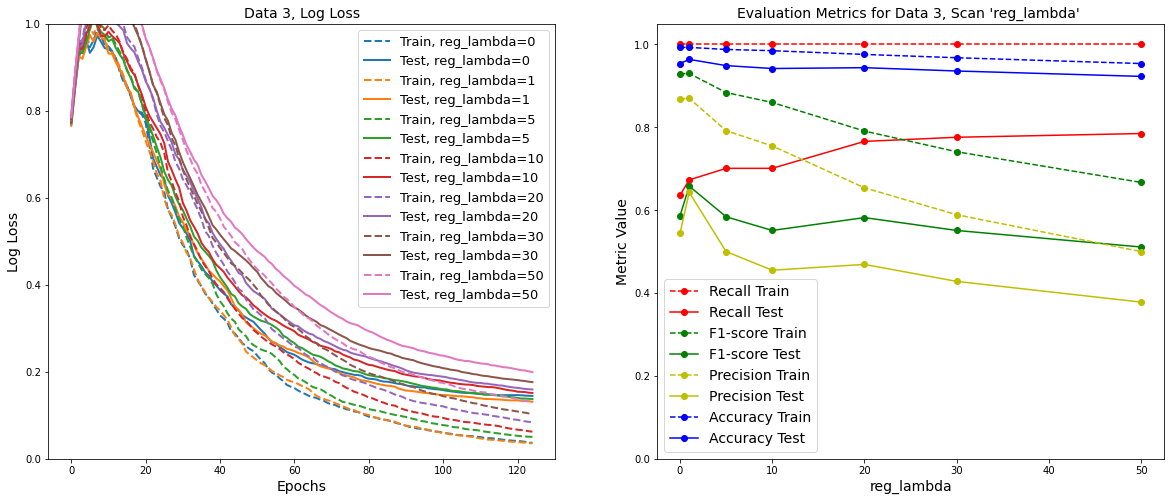

In [89]:
#Scan reg_lambda

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 20,
    'n_estimators': 125, 
    'max_depth': 5,
    'min_child_weight': 3,
    'gamma': 0,
    'learning_rate': 0.20,
    'max_delta_step': 0,
    'reg_alpha': 0,
    'subsample': 1,
}

scanParam = 'reg_lambda'

scanList = [0, 1, 5, 10, 20, 30, 50]  #default=1

result_lambda = scan_xgb_logloss_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 1, 1, 0)

In [90]:
result_lambda

,precision,recall,f1,accuracy,logloss
Params,,,,,
reg_lambda=0 Train,0.868,1.000,0.929,0.993,0.036
Test,0.544,0.636,0.586,0.954,0.144
reg_lambda=1 Train,0.870,1.000,0.930,0.993,0.035
Test,0.643,0.673,0.658,0.964,0.131
reg_lambda=5 Train,0.792,1.000,0.884,0.988,0.050
Test,0.500,0.701,0.584,0.949,0.137
reg_lambda=10 Train,0.755,1.000,0.860,0.985,0.062
Test,0.455,0.701,0.551,0.942,0.151
reg_lambda=20 Train,0.654,1.000,0.791,0.976,0.084


**Comments**

* For higher values of reg_lambda:
    * Overfitting decreases some
    * Recall increases
    * f1 and precision decreases significantly
* Optimum reg_lambda=1 (default)

### reg_alpha (L1)

Sample weights are used!
--------



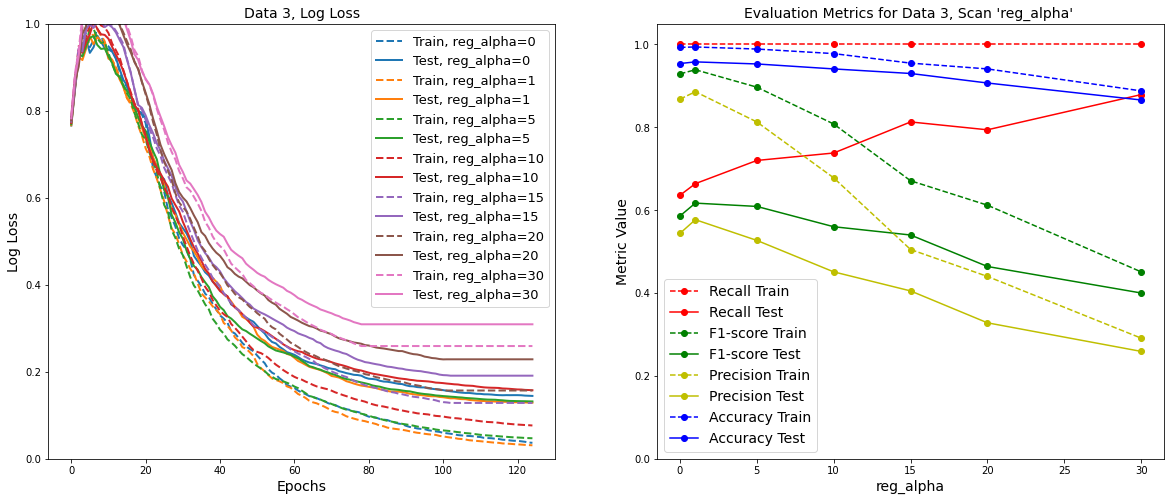

In [95]:
#Scan reg_alpha

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 20,
    'n_estimators': 125, 
    'max_depth': 5,
    'min_child_weight': 3,
    'gamma': 0,
    'learning_rate': 0.20,
    'max_delta_step': 0,
    'reg_lambda': 0,
    #'reg_alpha': 0,
    'subsample': 1,
}

scanParam = 'reg_alpha'

scanList = [0, 1, 5, 10, 15, 20, 30]

result_alpha = scan_xgb_logloss_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 1, 1, 0)

In [96]:
result_alpha

,precision,recall,f1,accuracy,logloss
Params,,,,,
reg_alpha=0 Train,0.868,1.000,0.929,0.993,0.036
Test,0.544,0.636,0.586,0.954,0.144
reg_alpha=1 Train,0.886,1.000,0.939,0.994,0.031
Test,0.577,0.664,0.617,0.958,0.129
reg_alpha=5 Train,0.813,1.000,0.897,0.989,0.047
Test,0.527,0.720,0.609,0.953,0.132
reg_alpha=10 Train,0.678,1.000,0.808,0.978,0.076
Test,0.451,0.738,0.560,0.941,0.157
reg_alpha=15 Train,0.505,1.000,0.671,0.955,0.128


**Comments**

* For higher values of reg_alpha:
    * The overfitting decreases significantly for all metrics
    * Recall increases
    * f1 and precision decreases significantly
* Optimum reg_alpha=5 (better than performance with reg_lambda=1)


### Model 6: Model after Regularization

In [17]:
# Model 6: Model after Regularization

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 20,
    'n_estimators': 125, 
    'max_depth': 5,
    'min_child_weight': 3,
    'gamma': 0,
    'learning_rate': 0.20,
    'max_delta_step': 0,
    'reg_lambda': 0,
    'reg_alpha': 5,
    'subsample': 1,
}

model_6 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams, 'model_6', 1, 1, 1)


Sample weights are used!
--------

Data 3 Classification Report:

Training Data:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      8014
           1       0.81      1.00      0.90       388

    accuracy                           0.99      8402
   macro avg       0.91      0.99      0.95      8402
weighted avg       0.99      0.99      0.99      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      1994
           1       0.53      0.72      0.61       107

    accuracy                           0.95      2101
   macro avg       0.76      0.84      0.79      2101
weighted avg       0.96      0.95      0.96      2101



In [98]:
model_6.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=5, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=125, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=5, reg_lambda=0,
              scale_pos_weight=20, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)>

,precision,recall,f1,accuracy,auc
Params,,,,,
Model 1 Train,1.000,1.000,1.000,1.000,1.000
Test,0.926,0.467,0.621,0.971,0.941
Model 2 Train,0.990,1.000,0.995,1.000,1.000
Test,0.677,0.607,0.640,0.965,0.916
Model 3 Train,0.956,1.000,0.977,0.998,1.000
Test,0.645,0.645,0.645,0.964,0.922
Model 4 Train,0.902,1.000,0.949,0.995,1.000
Test,0.602,0.692,0.643,0.961,0.921
Model 5 Train,0.870,1.000,0.930,0.993,1.000


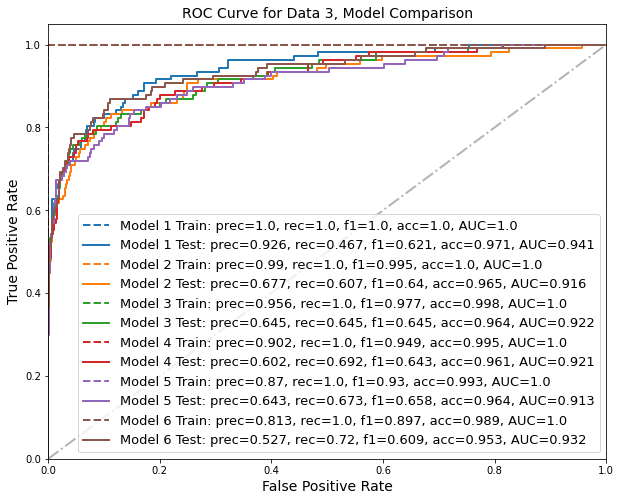

In [22]:
model_list = [model_1, model_2, model_3, model_4, model_5, model_6]
model_names_list = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']

compare_models(3, X_train, y_train, X_test, y_test, model_list, model_names_list, 'Model_l-6', 1, 1)

**Comments**
* Model performance is improved.
* recall and AUC increased significantly.
* f1 and precision decreased.
* Overfitting decreased.

## Sampling Parameters Tuning

### subsample

Sample weights are used!
--------



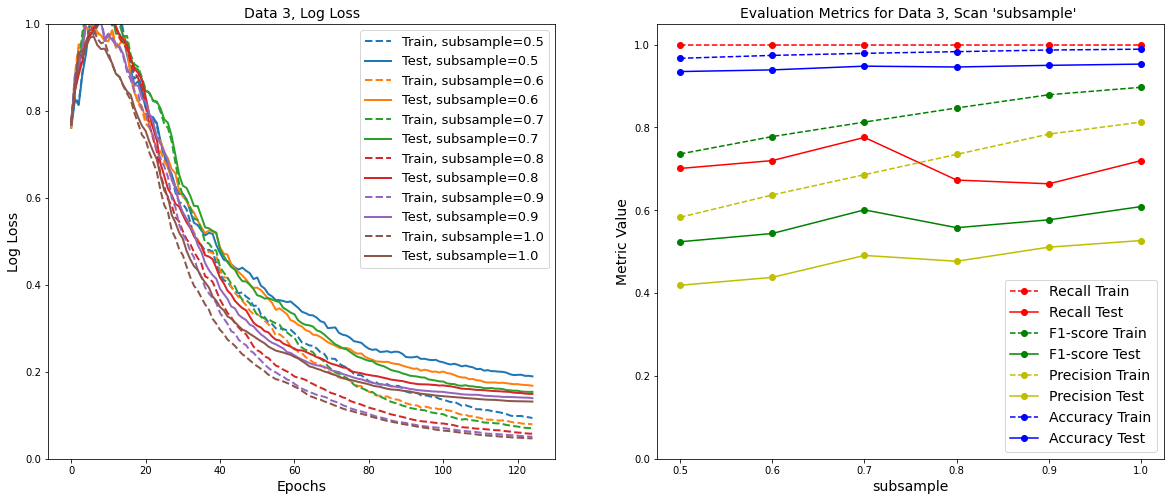

In [101]:
#Scan subsample

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 20,
    'n_estimators': 125, 
    'max_depth': 5,
    'min_child_weight': 3,
    'gamma': 0,
    'learning_rate': 0.20,
    'max_delta_step': 0,
    'reg_lambda': 0,
    'reg_alpha': 5,
    #'subsample': 1,
}

scanParam = 'subsample'

scanList = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

result_subsample = scan_xgb_logloss_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 1, 1, 0)


In [102]:
result_subsample

,precision,recall,f1,accuracy,logloss
Params,,,,,
subsample=0.5 Train,0.583,1.000,0.736,0.967,0.094
Test,0.419,0.701,0.524,0.935,0.190
subsample=0.6 Train,0.637,1.000,0.778,0.974,0.079
Test,0.438,0.720,0.544,0.939,0.168
subsample=0.7 Train,0.686,1.000,0.813,0.979,0.071
Test,0.491,0.776,0.601,0.948,0.154
subsample=0.8 Train,0.735,1.000,0.847,0.983,0.058
Test,0.477,0.673,0.558,0.946,0.149
subsample=0.9 Train,0.784,1.000,0.879,0.987,0.051


**Comments**

* Overfitting is larger at higher values of subsample
* Optimum: subsample=0.7

### colsample_bytree

Sample weights are used!
--------



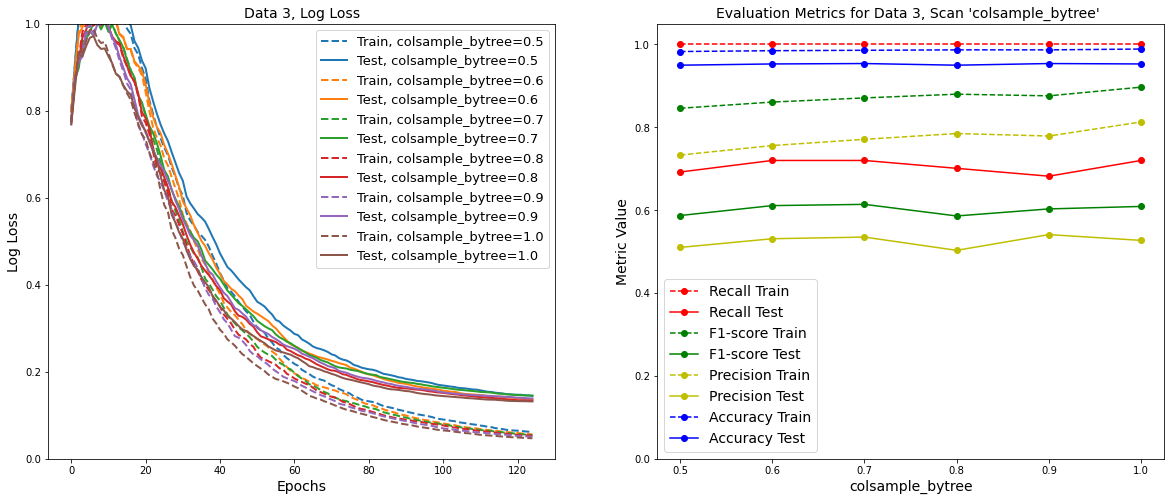

In [103]:
#Scan colsample_bytree

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 20,
    'n_estimators': 125, 
    'max_depth': 5,
    'min_child_weight': 3,
    'gamma': 0,
    'learning_rate': 0.20,
    'max_delta_step': 0,
    'reg_lambda': 0,
    'reg_alpha': 5,
    'subsample': 1,
}

scanParam = 'colsample_bytree'

scanList = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

result_colsample = scan_xgb_logloss_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 1, 1, 0)


In [104]:
result_colsample

,precision,recall,f1,accuracy,logloss
Params,,,,,
colsample_bytree=0.5 Train,0.733,1.000,0.846,0.983,0.061
Test,0.510,0.692,0.587,0.950,0.144
colsample_bytree=0.6 Train,0.756,1.000,0.861,0.985,0.056
Test,0.531,0.720,0.611,0.953,0.137
colsample_bytree=0.7 Train,0.771,1.000,0.871,0.986,0.054
Test,0.535,0.720,0.614,0.954,0.145
colsample_bytree=0.8 Train,0.785,1.000,0.880,0.987,0.053
Test,0.503,0.701,0.586,0.950,0.134
colsample_bytree=0.9 Train,0.779,1.000,0.876,0.987,0.050


**Comments**

* colsample_bytree has no significant effect on model performance
* overfitting decreases very sligtly at lower values
* Optimum: colsample_bytree=0.7

### Model 7: Model after Sampling

In [19]:
#Model 7: Model after Sampling

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 20,
    'n_estimators': 125, 
    'max_depth': 5,
    'min_child_weight': 3,
    'gamma': 0,
    'learning_rate': 0.20,
    'max_delta_step': 0,
    'reg_lambda': 0,
    'reg_alpha': 5,
    'subsample': 1,
    'colsample_bytree': 0.7
}

model_7 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams, 'model_7', 1, 1, 1)


Sample weights are used!
--------

Data 3 Classification Report:

Training Data:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      8014
           1       0.77      1.00      0.87       388

    accuracy                           0.99      8402
   macro avg       0.89      0.99      0.93      8402
weighted avg       0.99      0.99      0.99      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      1994
           1       0.53      0.72      0.61       107

    accuracy                           0.95      2101
   macro avg       0.76      0.84      0.79      2101
weighted avg       0.96      0.95      0.96      2101



In [106]:
model_7.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=5, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=125, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=5, reg_lambda=0,
              scale_pos_weight=20, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)>

,precision,recall,f1,accuracy,auc
Params,,,,,
Model 1 Train,1.000,1.000,1.000,1.000,1.000
Test,0.926,0.467,0.621,0.971,0.941
Model 2 Train,0.990,1.000,0.995,1.000,1.000
Test,0.677,0.607,0.640,0.965,0.916
Model 3 Train,0.956,1.000,0.977,0.998,1.000
Test,0.645,0.645,0.645,0.964,0.922
Model 4 Train,0.902,1.000,0.949,0.995,1.000
Test,0.602,0.692,0.643,0.961,0.921
Model 5 Train,0.870,1.000,0.930,0.993,1.000


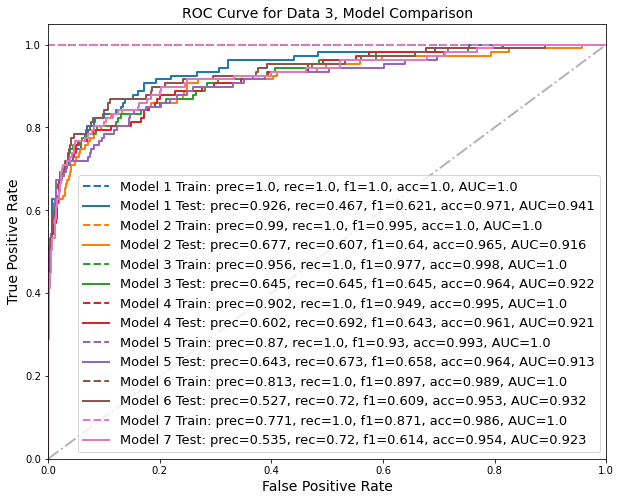

In [23]:
model_list = [model_1, model_2, model_3, model_4, model_5, model_6, model_7]
model_names_list = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6', 'Model 7']

compare_models(3, X_train, y_train, X_test, y_test, model_list, model_names_list, 'Model_l-7', 1, 1)

**Comments**
* Overfitting decreased.
* recall stays same, but f1 and precision increased.

## Final Model

Model 7 is the best model.

In [137]:
xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 20,
    'n_estimators': 125, 
    'max_depth': 5,
    'min_child_weight': 3,
    'gamma': 0,
    'learning_rate': 0.20,
    'max_delta_step': 0,
    'reg_lambda': 0,
    'reg_alpha': 5,
    'subsample': 1,
    'colsample_bytree': 0.7,
}

final_model = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams, 'Final_Model', 1, 1, 1)

Sample weights are used!
--------

Data 3 Classification Report:

Training Data:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      8014
           1       0.77      1.00      0.87       388

    accuracy                           0.99      8402
   macro avg       0.89      0.99      0.93      8402
weighted avg       0.99      0.99      0.99      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      1994
           1       0.53      0.72      0.61       107

    accuracy                           0.95      2101
   macro avg       0.76      0.84      0.79      2101
weighted avg       0.96      0.95      0.96      2101



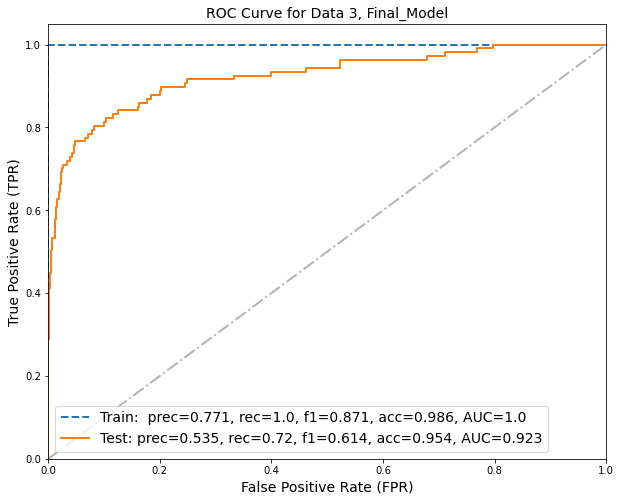

In [112]:
plot_ROC(3, X_train, y_train, X_test, y_test, final_model, 'Final_Model', 1)

In [111]:
final_model.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=5, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=125, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=5, reg_lambda=0,
              scale_pos_weight=20, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)>

In [116]:
d3_importance = final_model.feature_importances_

In [136]:
d3_attribute_importance = pd.DataFrame([df3.columns, d3_importance], index=['Attribute', 'Importance Weight']).T
d3_attribute_importance.set_index('Attribute', inplace=True)
d3_attribute_importance.sort_values(by='Importance Weight', ascending=False, inplace=True)
d3_attribute_importance.head(20)

,Importance Weight
Attribute,
Attr34,0.0460207
Attr52,0.0451953
Attr10,0.041293
Attr26,0.0389812
Attr27,0.0360403
Attr25,0.0342285
Attr35,0.0327538
Attr19,0.0286496
Attr59,0.0275013
